In [2]:
import os
import json
import random
import pandas as pd
import numpy as np
import pubchempy as pcp
from rdkit import Chem
from compute_fp_note import Compute_FP
from tensorflow.keras.models import load_model
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors

In [3]:
candidates = pd.read_csv('phase3_candidates.csv')

In [4]:
candidates

,cid,name,condition,mechanism_of_action,clinical_trial_id,MATC_code_short,label
0,118892432,Rilematovir,Respiratory Syncytial Virus (RSV) Infection,inhibitor of the RSV viral fusion glycoprotein,NCT04978337,J,7
1,9795739,Pridopidine,Hungtington's Disease,activator of sigma-1 CNS receptor (S1R),NCT04556656,N,10
2,11977753,Dactolisib,Endometrial Carcinoma,PI3K and mTOR inhibitor,NCT01290406,L,8
3,60194102,Proxalutamide,COVID-19 Infection,high-affinity silent antagonist of the androge...,NCT05009732,J,7
4,72704611,Deuruxolitinib,Severe Alopecia Areata,inhibitor of Janus kinase 1 (JAK1) and JAK2 en...,NCT04518995,D,3
5,16659285,Ridinilazole,Clostridioides Difficile Infection,minor groove DNA binder,NCT04802837,J,7
6,118253852,Brensocatib,Non-Cystic Fibrosis Bronchiectasis,inhibitor of dipeptidyl peptidase-1 of neutrop...,NCT04594369,L,8
7,70912,N-Acetyl-L-leucine,Niemann-Pick Type C1 (NPC1) Disease,neuronal calcium channel modulator,NCT05163288,N,10
8,172997,Lixivaptan,Autosomal Dominant Polycystic Kidney Disease,vasopressin 2 receptor antagonist,NCT04064346,C,2
9,643985,Dextromethadone,Major Depressive Disorder,modulation of neuron NMDA receptors,NCT05081167,N,10


In [5]:
with open(os.path.join('..', 'data', '05_model_input', 'selected_fp.txt')) as file:
    selected_fp = file.readline()

In [6]:
def get_smiles(cid):
    try:
        compound = pcp.Compound.from_cid(cid)
        return compound.isomeric_smiles
    except:
        'no smiles found'
        return None

In [7]:
def get_rdkit_molecule(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        print('no molecule found')
        return None

In [8]:
computer = Compute_FP()
def get_fp(mol):
    return computer.relate_fp_functions(selected_fp, mol)

In [9]:
candidates['smiles'] = candidates['cid'].map(get_smiles)
candidates['molecule'] = candidates['smiles'].map(get_rdkit_molecule)
candidates['fingerprints'] = candidates['molecule'].map(get_fp)

In [10]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cid                  20 non-null     int64 
 1   name                 20 non-null     object
 2   condition            20 non-null     object
 3   mechanism_of_action  20 non-null     object
 4   clinical_trial_id    20 non-null     object
 5   MATC_code_short      20 non-null     object
 6   label                20 non-null     int64 
 7   smiles               20 non-null     object
 8   molecule             20 non-null     object
 9   fingerprints         20 non-null     object
dtypes: int64(2), object(8)
memory usage: 1.7+ KB


In [11]:
model = load_model(os.path.join('..', 'data', '06_models', 'def_model.hd5'))

In [12]:
fingerprints = np.array(list(candidates['fingerprints']))
reshaped_fps = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1], 1))

In [13]:
probs = model.predict(reshaped_fps)
preds = [np.argmax(x) for x in probs]
max_probs = [np.max(x) for x in probs]


1/1 [==============================] - 0s 114ms/step


In [14]:
candidates['prediction'] = preds
candidates['probability'] = max_probs

In [15]:
from sklearn import metrics

In [16]:
safe_candidates = candidates[candidates['probability']>0.8]
print(metrics.classification_report(safe_candidates['label'], safe_candidates['prediction']))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3

    accuracy                           0.71         7
   macro avg       0.50      0.60      0.53         7
weighted avg       0.64      0.71      0.67         7



c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [17]:
candidates[candidates['label']==candidates['prediction']][['cid','name','label','prediction','probability']].groupby('label').value_counts()

label  cid        name                prediction  probability
7      163358784  Deuremidevir        7           0.879209       1
8      11977753   Dactolisib          8           0.816242       1
       44623998   Etrasimod           8           0.394294       1
       118253852  Brensocatib         8           0.390182       1
10     70912      N-Acetyl-L-leucine  10          0.991990       1
       643985     Dextromethadone     10          0.999991       1
       9795739    Pridopidine         10          0.824893       1
Name: count, dtype: int64

In [18]:
candidates[candidates['label']!=candidates['prediction']][['cid', 'name', 'label', 'prediction', 'probability']].groupby('label').value_counts()

label  cid        name            prediction  probability
0      11236126   Seladelpar      2           0.704986       1
1      10257882   Sparsentan      2           0.810624       1
       118277544  Milvexian       7           0.897134       1
2      172997     Lixivaptan      7           0.379510       1
3      72704611   Deuruxolitinib  7           0.572343       1
7      16659285   Ridinilazole    8           0.476822       1
       60194102   Proxalutamide   10          0.462669       1
       118892432  Rilematovir     10          0.516604       1
10     6098167    (r)-Oxybutynin  4           0.668176       1
       9882189    Blarcamesine    13          0.500853       1
       11528958   Verdiperstat    3           0.210203       1
       46195331   Simufilam       0           0.449461       1
       86294073   Zuranolone      7           0.195335       1
Name: count, dtype: int64

In [19]:
from sklearn import metrics

In [20]:
metrics.classification_report(candidates['label'],candidates['prediction'])

c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.00      0.00      0.00         2\n           2       0.00      0.00      0.00         1\n           3       0.00      0.00      0.00         1\n           4       0.00      0.00      0.00         0\n           7       0.20      0.25      0.22         4\n           8       0.75      1.00      0.86         3\n          10       0.60      0.38      0.46         8\n          13       0.00      0.00      0.00         0\n\n    accuracy                           0.35        20\n   macro avg       0.17      0.18      0.17        20\nweighted avg       0.39      0.35      0.36        20\n'

In [ ]:
''''              precision    recall  f1-score   support
\n
\n           0       0.00      0.00      0.00         1
\n           1       0.00      0.00      0.00         2
\n           2       0.00      0.00      0.00         1
\n           3       0.00      0.00      0.00         1
\n           4       0.00      0.00      0.00         0
\n           7       0.20      0.25      0.22         4
\n           8       0.75      1.00      0.86         3
\n          10       0.60      0.38      0.46         8
\n          13       0.00      0.00      0.00         0
\n
\n    accuracy                           0.35        20
\n   macro avg       0.17      0.18      0.17        20
\nweighted avg       0.39      0.35      0.36        20\n'
'''

In [21]:
print(metrics.classification_report(candidates['label'],candidates['prediction']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           7       0.20      0.25      0.22         4
           8       0.75      1.00      0.86         3
          10       0.60      0.38      0.46         8
          13       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.17      0.18      0.17        20
weighted avg       0.39      0.35      0.36        20



c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [22]:
clas_rep = """precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           7       0.50      0.25      0.33         4
           8       0.38      1.00      0.55         3
          10       1.00      0.75      0.86         8"""

In [36]:
clas_rep = metrics.classification_report(candidates['label'],candidates['prediction'])

c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josin\anaconda3\envs\kedro-environment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [124]:
display(metrics.accuracy_score(candidates['label'],candidates['prediction']))


0.35

In [37]:
import matplotlib.pyplot as plt

In [38]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

In [39]:
def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [40]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

In [41]:
with open(os.path.join('..', 'data', '03_primary', 'code_to_label_dic.json')) as codes:
    label_dic = json.load(codes)

In [114]:
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    #classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines))-6]:
        t = line.strip().split()
        if len(t) < 2: continue
        #classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))
    class_names = [label_dic[str(key)] for key in class_names]
    
    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

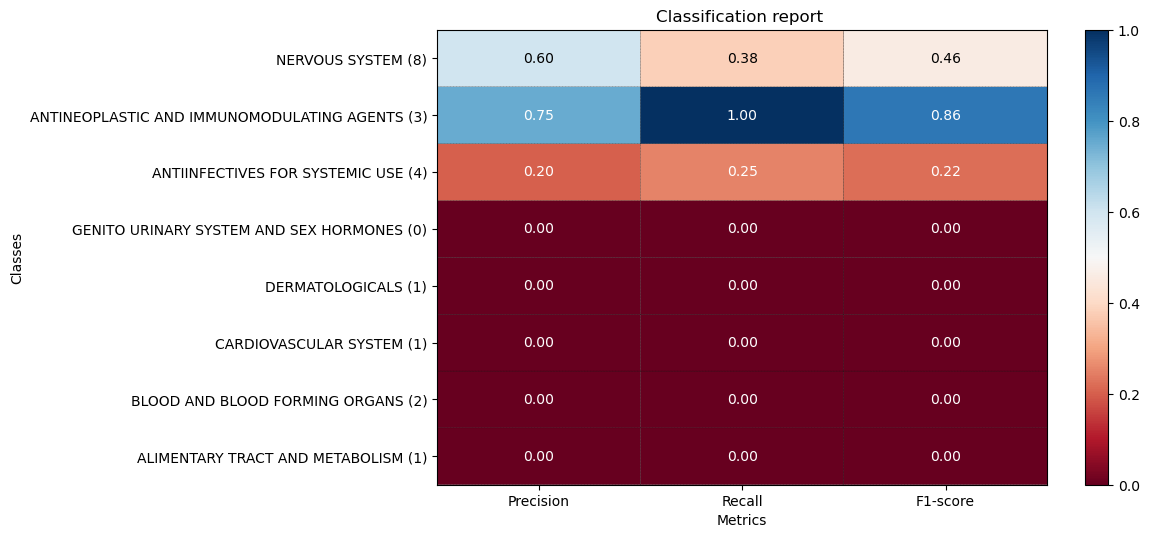

In [115]:
plot_classification_report(clas_rep)

In [100]:
drugs_w_mol = pd.read_pickle('../data/05_model_input/input_table.pickle/2023-09-07T18.33.38.013Z/input_table.pickle')

In [31]:
fingerprints = np.array(list(drugs_w_mol[selected_fp]))
reshaped_fps = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1], 1))

In [32]:
probs = model.predict(reshaped_fps)
preds = [np.argmax(x) for x in probs]
max_probs = [np.max(x) for x in probs]

310/310 [==============================] - 3s 10ms/step


In [33]:
print(metrics.classification_report(drugs_w_mol['Label'],preds))

              precision    recall  f1-score   support

           0       0.65      0.81      0.72       767
           1       0.88      0.65      0.75       439
           2       0.87      0.78      0.82      1051
           3       0.70      0.61      0.66       346
           4       0.82      0.74      0.78       308
           5       0.78      0.64      0.70       108
           6       0.75      0.66      0.70       276
           7       0.87      0.90      0.89      2524
           8       0.82      0.84      0.83      1390
           9       0.75      0.69      0.72       189
          10       0.76      0.86      0.81      1456
          11       0.90      0.79      0.84       141
          12       0.87      0.46      0.60       141
          13       0.71      0.72      0.72       310
          14       0.82      0.54      0.65       161
          15       0.80      0.70      0.75       302

    accuracy                           0.80      9909
   macro avg       0.80   

In [34]:
drugs_w_mol_class_rep = """precision    recall  f1-score   support

           0       0.80      0.76      0.78       777
           1       0.80      0.73      0.76       449
           2       0.82      0.81      0.81      1072
           3       0.74      0.58      0.65       350
           4       0.82      0.78      0.80       312
           5       0.69      0.72      0.70       111
           6       0.75      0.79      0.77       277
           7       0.86      0.92      0.89      2570
           8       0.83      0.87      0.85      1420
           9       0.81      0.57      0.67       195
          10       0.79      0.87      0.83      1474
          11       0.88      0.79      0.83       143
          12       0.85      0.49      0.62       146
          13       0.81      0.66      0.73       321
          14       0.76      0.49      0.59       166
          15       0.79      0.75      0.77       307"""

In [35]:
plot_classification_report(drugs_w_mol_class_rep)

KeyError: '15'

In [119]:
what = load_model(os.path.join('..', 'data', '06_models', 'history.pickle'))


OSError: Unable to synchronously open file (file signature not found)

In [120]:
with open(os.path.join('..', 'data', '08_reporting', 'classiffication_report.txt')) as file:
    clas_rep = file.read()

In [121]:
clas_rep

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         3\n           1       0.00      0.00      0.00         2\n           2       0.67      0.33      0.44         6\n           3       0.50      0.33      0.40         3\n           4       0.85      0.85      0.85        20\n           7       0.67      0.33      0.44         6\n           8       0.25      0.40      0.31         5\n           9       0.00      0.00      0.00         1\n          10       0.36      0.83      0.50         6\n          11       0.00      0.00      0.00         2\n          13       0.00      0.00      0.00         0\n          14       0.00      0.00      0.00         4\n\n    accuracy                           0.50        58\n   macro avg       0.27      0.26      0.25        58\nweighted avg       0.52      0.50      0.48        58\n'

In [125]:
print(clas_rep)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.67      0.33      0.44         6
           3       0.50      0.33      0.40         3
           4       0.85      0.85      0.85        20
           7       0.67      0.33      0.44         6
           8       0.25      0.40      0.31         5
           9       0.00      0.00      0.00         1
          10       0.36      0.83      0.50         6
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         4

    accuracy                           0.50        58
   macro avg       0.27      0.26      0.25        58
weighted avg       0.52      0.50      0.48        58



In [126]:
lines = clas_rep.split('\n')

In [159]:
accuracy_score = lines[-4:-3][0][-15:-5].strip()

In [160]:
float(accuracy_score)

0.5